In [3]:
import os
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

In [5]:
import openai
import json

In [4]:
openai.api_key = 'placeholder_holder_open_key'

In [6]:
import openai
import pandas as pd
import os
import wget
from ast import literal_eval

# Chroma's client library for Python
import chromadb

# I've set this to our new embeddings model, this can be changed to the embedding model of your choice
EMBEDDING_MODEL = "text-embedding-ada-002"

# Ignore unclosed SSL socket warnings - optional in case you get these errors
import warnings

warnings.filterwarnings(action="ignore", message="unclosed", category=ResourceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
import zipfile
with zipfile.ZipFile("vector_database_wikipedia_articles_embedded.zip","r") as zip_ref:
    zip_ref.extractall("../data")

In [8]:
article_df = pd.read_csv('C:\\Users\\anubr\\java projects\\AI_ML\\OpenAI\\arnexa\\vector_database_wikipedia_articles_embedded\\vector_database_wikipedia_articles_embedded.csv')

In [9]:
article_df.head()

,id,url,title,text,title_vector,content_vector,vector_id
0,1,https://simple.wikipedia.org/wiki/April,April,April is the fourth month of the year in the J...,"[0.001009464613161981, -0.020700545981526375, ...","[-0.011253940872848034, -0.013491976074874401,...",0
1,2,https://simple.wikipedia.org/wiki/August,August,August (Aug.) is the eighth month of the year ...,"[0.0009286514250561595, 0.000820168002974242, ...","[0.0003609954728744924, 0.007262262050062418, ...",1
2,6,https://simple.wikipedia.org/wiki/Art,Art,Art is a creative activity that expresses imag...,"[0.003393713850528002, 0.0061537534929811954, ...","[-0.004959689453244209, 0.015772193670272827, ...",2
3,8,https://simple.wikipedia.org/wiki/A,A,A or a is the first letter of the English alph...,"[0.0153952119871974, -0.013759135268628597, 0....","[0.024894846603274345, -0.022186409682035446, ...",3
4,9,https://simple.wikipedia.org/wiki/Air,Air,Air refers to the Earth's atmosphere. Air is a...,"[0.02224554680287838, -0.02044147066771984, -0...","[0.021524671465158463, 0.018522677943110466, -...",4


In [12]:
article_df['title_vector'] = article_df.title_vector.apply(literal_eval)
article_df['content_vector'] = article_df.content_vector.apply(literal_eval)

# Set vector_id to be a string
article_df['vector_id'] = article_df['vector_id'].apply(str)

In [10]:
article_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              25000 non-null  int64 
 1   url             25000 non-null  object
 2   title           25000 non-null  object
 3   text            25000 non-null  object
 4   title_vector    25000 non-null  object
 5   content_vector  25000 non-null  object
 6   vector_id       25000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.3+ MB


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'vector_id'}>]], dtype=object)

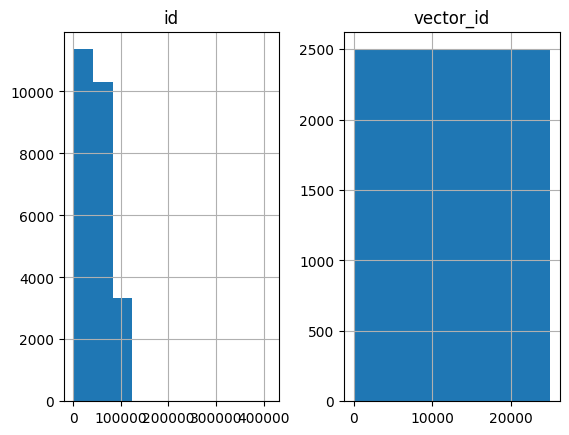

In [11]:
article_df.hist()

In [7]:
chroma_client = chromadb.EphemeralClient() # Equivalent to chromadb.Client(), ephemeral.

In [13]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
embedding_function = OpenAIEmbeddingFunction(api_key=os.environ.get('OPENAI_API_KEY'), model_name=EMBEDDING_MODEL)
embedding_function

In [16]:

wikipedia_content_collection = chroma_client.create_collection(name='wikipedia_content', embedding_function=embedding_function)


ValueError: Collection wikipedia_content already exists.

In [17]:
wikipedia_title_collection = chroma_client.create_collection(name='wikipedia_titles', embedding_function=embedding_function)
wikipedia_title_collection

ValueError: Collection wikipedia_titles already exists.

In [18]:
# Add the content vectors
wikipedia_content_collection.add(
    ids=article_df.vector_id.tolist(),
    embeddings=article_df.content_vector.tolist(),
)

# Add the title vectors
wikipedia_title_collection.add(
    ids=article_df.vector_id.tolist(),
    embeddings=article_df.title_vector.tolist(),
)

In [19]:
def query_collection(collection, query, max_results, dataframe):
    results = collection.query(query_texts=query, n_results=max_results, include=['distances']) 
    df = pd.DataFrame({
                'id':results['ids'][0], 
                'score':results['distances'][0],
                'title': dataframe[dataframe.vector_id.isin(results['ids'][0])]['title'],
                'content': dataframe[dataframe.vector_id.isin(results['ids'][0])]['text'],
                })
    
    return df

In [20]:
title_query_result = query_collection(
    collection=wikipedia_title_collection,
    query="modern art in Europe",
    max_results=10,
    dataframe=article_df
)
title_query_result.head()

,id,score,title,content
116,12249,0.265118,Europe,Europe is the western part of the continent of...
1332,12248,0.290684,European,European may mean:\nA person or attribute of t...
2885,12225,0.314833,Scandinavia,Scandinavia is a group of countries in norther...
12212,1332,0.317179,Western civilization,"Western civilization, western culture or the ..."
12216,12216,0.321235,Eastern Europe,Eastern Europe is the eastern region of Europe...


In [21]:
content_query_result = query_collection(
    collection=wikipedia_content_collection,
    query="Famous battles in Scottish history",
    max_results=10,
    dataframe=article_df
)
content_query_result.head()

,id,score,title,content
2923,13135,0.261328,1651,\n\nEvents \n January 1 – Charles II crowned K...
3694,13571,0.277059,Stirling,Stirling () is a city in the middle of Scotlan...
6248,2923,0.294823,841,\n\nEvents \n June 25: Battle of Fontenay – Lo...
6297,13568,0.300756,1746,\n\nEvents \n January 8 – Bonnie Prince Charli...
11702,11708,0.307572,William Wallace,William Wallace was a Scottish knight who foug...
